In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import pyarrow.parquet as pq
import numpy as np

import pennylane.numpy as pnp
import pennylane as qml
import jax
from tqdm import tqdm
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from jax_utils import square_kernel_matrix_jax, kernel_matrix_jax, target_alignment_jax
from pathlib import Path
from torch_geometric.nn import knn_graph
from torch_geometric.utils import to_undirected, k_hop_subgraph, is_undirected
import pandas as pd
import pyarrow as pa
from itertools import zip_longest
import networkx as nx
from sklearn.decomposition import PCA, KernelPCA
from jax.config import config
config.update("jax_enable_x64", True)

import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.utils import to_dense_batch, to_dense_adj, k_hop_subgraph, to_networkx
import torch
import jax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from time import time
from itertools import zip_longest
import networkx as nx

import torch
seed = 42
np.random.seed(seed)
pnp.random.seed(seed)

jax.devices()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [3]:
def node_hindex_centrality(graph):
    numNode = graph.number_of_nodes()
    TotalDeg = np.array(list(graph.degree(graph.nodes())))[:, 1]
    Nei = [list(iter(graph[i])) for i in graph.nodes()]

    Hn = []
    Hi = [0] * numNode
    Hn.append(TotalDeg)

    for inter in range(1, numNode):
        Hitmp = np.array(Hn[inter - 1])
#         print(Hitmp)

        for iNode in range(0, numNode):
            index = Nei[iNode]
            iDegree = np.sort(Hitmp[index])[::-1]
            Hi[iNode] = len(
                np.where(iDegree - np.arange(1,
                                             len(iDegree) + 1) >= 0)[0])

        Hn.append(Hi.copy())
        
        if list(Hn[-1]) == list(Hn[-2]):
            break
    
    return np.array(Hn[:-1])


def Entropy_Shannon(X):
    # For discrete data
    data = np.unique(X)
    numData = len(data)
    Frequency = [0] * numData

    for index in range(numData):
        Frequency[index] = np.sum(X == data[index])

    P = Frequency / np.sum(Frequency)
    H = -np.sum(P * np.log2(P))

    return H


def dhce(graph):
    Hn = node_hindex_centrality(graph)
    maxDim = Hn.shape[0]
    EnGraph = [0] * maxDim

    for ih in range(maxDim):
        EnGraph[ih] = Entropy_Shannon(Hn[ih])
    
    return EnGraph

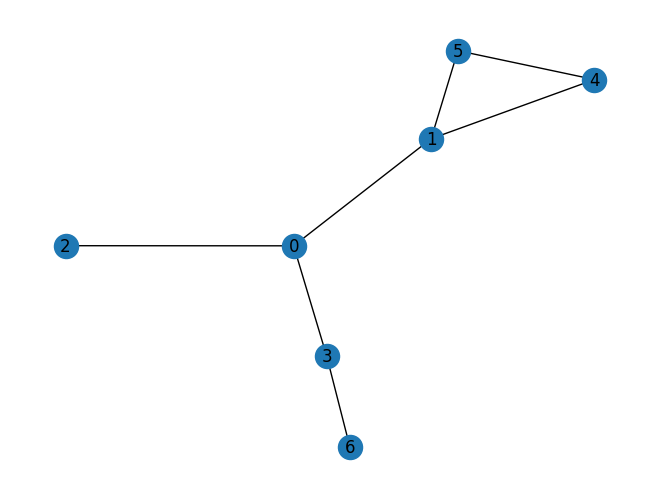

In [4]:
# Create a sample graph (you can replace this with your own graph)
G = nx.Graph()
# G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 4), (4, 5)])
# G.add_edges_from([
#     (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (1,2), (1,3), (2,3), (3,8), (4,5), (6, 7)
# ])
G.add_edges_from([
    (0,1), (0,2), (0,3), (1, 4), (1, 5), (3, 6), (4,5)
])
# G = nx.erdos_renyi_graph(n = 10, p = 0.8)
nx.draw(G, with_labels=True)

In [5]:
dhce(G)

[1.5566567074628228, 0.9852281360342515, 0.9852281360342515]

In [6]:
DATASET_PATH = "./data"
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH,
                                                name="MUTAG")
tu_dataset.shuffle()

import torch_geometric.transforms as T
# transform = T.Compose([T.Pad(28, 66)])
# tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG", transform=transform)

tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")
tu_dataset.get_summary()

TUDataset (#graphs=188):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     17.9 |     39.6 |
| std        |      4.6 |     11.4 |
| min        |     10   |     20   |
| quantile25 |     14   |     28   |
| median     |     17   |     38   |
| quantile75 |     22   |     50   |
| max        |     28   |     66   |
+------------+----------+----------+

In [7]:
temp_en_graphs = []
data = tu_dataset[0]
graph = to_networkx(data).to_undirected()

smax = 0
y = []
for data in tu_dataset:
    graph = to_networkx(data).to_undirected()
    y.append(int(data.y[0]))
    temp_en_graphs.append(dhce(graph))
    smax = max(smax, len(temp_en_graphs[-1]))
    
en_graphs = []
for data in temp_en_graphs:
    en_graphs.append(data + [data[-1]]*(smax - len(data)))
en_graphs = np.array(en_graphs)

In [10]:
en_graphs.shape

(188, 4)

In [12]:
np.array(y)

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0])

In [8]:
pca = PCA(n_components=2)
x = pca.fit_transform(en_graphs)

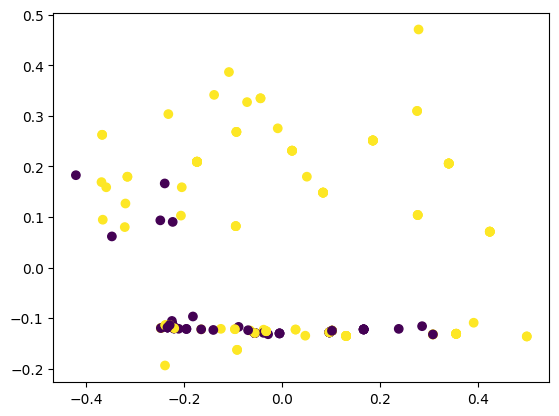

In [9]:
plt.scatter(x[:, 0], x[:, 1], c=y)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x, y)
print(neigh.score(x, y))
roc_auc_score(y, neigh.predict_proba(x)[:,1])

0.8776595744680851


0.9257777777777776

In [39]:
def generate(pf, path, iter_batch_size, max_batches, zero_idx, one_idx, prefix):
    record_batch = pf.iter_batches(batch_size=iter_batch_size)
    count = 0
    
    while True:
        try:
            batch = next(record_batch)
            zero_idx, one_idx = transform_to_graph(batch, path, zero_idx, one_idx, prefix)
            count += 1
            break
        except StopIteration as e:
            print(e)
            return zero_idx, one_idx

        if count == max_batches:
            break

    return zero_idx, one_idx

In [40]:
def transform_to_graph(batch, path, zero_idx, one_idx, prefix):
    p = batch.to_pandas()
    im = np.array(np.array(np.array(p.iloc[:, 0].tolist()).tolist()).tolist())
    meta = np.array(p.iloc[:, 3])
    return saver(im, meta, path, zero_idx, one_idx, prefix)

In [93]:
from torch.nn.functional import pad
from torch_geometric.utils import to_dense_batch, to_dense_adj
from time import time

max_nodes = 1024
max_ego_nodes = 0

graphs = []
y = []
smax = 0

def saver(im, meta, path, zero_idx, one_idx, prefix):

    im[im < 1.e-3] = 0 #Zero_suppression
    # im[:,0,:,:] = (im[:,0,:,:] - im[:,0,:,:].mean())/(im[:,0,:,:].std())
    # im[:,1,:,:] = (im[:,1,:,:] - im[:,1,:,:].mean())/(im[:,1,:,:].std())
    # im[:,2,:,:] = (im[:,2,:,:] - im[:,2,:,:].mean())/(im[:,2,:,:].std())

    new_file = True
    
    with tqdm(range(meta.shape[0]), unit='datum') as tbatch:   
        for i in tbatch:
            img = im[i,:,:,:]
            label = int(meta[i])

#             channel1 = img[0,:,:]
#             channel2 = img[1,:,:]
#             channel3 = img[2,:,:]

#             channel1 = np.clip(channel1, 0, 500*channel1.std())
#             channel2 = np.clip(channel2, 0, 500*channel2.std())
#             channel3 = np.clip(channel3, 0, 500*channel3.std())

#             p = channel1.max() == 0.0
#             q = channel2.max() == 0.0
#             r = channel3.max() == 0.0

#             if p | q | r:
#                 continue

#             channel1 = channel1/channel1.max()
#             channel2 = channel2/channel2.max()
#             channel3 = channel3/channel3.max()

#             img[0,:,:] = channel1
#             img[1,:,:] = channel2
#             img[2,:,:] = channel3

            img = img.T

            # graph conversion
            img = torch.Tensor(img)
            xhit, yhit, zhit = torch.nonzero(img, as_tuple=True)
            
            # print(xhit.shape, yhit.shape, zhit.shape)
            
            # indices
            chs = [(zhit == 0).nonzero(as_tuple=True)[0], 
                   (zhit == 1).nonzero(as_tuple=True)[0], 
                   (zhit == 2).nonzero(as_tuple=True)[0]]

            hcal_coordinates = torch.stack((xhit[chs[2]], yhit[chs[2]])).T
            hcal_values =  img[xhit[chs[2]], yhit[chs[2]], 2]
            
            assert hcal_coordinates.shape[0]%5 == 0
            
            # print(hcal_indices.shape)
            # Reshape the padded array into groups of 5 elements
            grouped_coordinates = hcal_coordinates.reshape(-1, 5, 2).to(torch.float32)
            grouped_values = hcal_values.reshape(-1, 5)
#             print(grouped_indices)
#             print(grouped_values)
            
            # Calculate the mean along the second axis (axis=1)
            mean_coordinates = torch.mean(grouped_coordinates, axis=1).numpy()
#             print(mean_indices)
            mean_values = torch.mean(grouped_values, axis=1)
#             print(mean_values)
            
            mean_coordinates = mean_coordinates[np.lexsort((mean_coordinates[:, 0], mean_coordinates[:, 1]))]
            
#             print(mean_indices)
            
            mean_coordinates = torch.tensor(mean_coordinates)
        
            grouped_coordinates = mean_coordinates.reshape(-1, 5, 2).to(torch.float32)
            grouped_values = mean_values.reshape(-1, 5)
#             print(grouped_indices)
#             print(grouped_values)
            
            mean_coordinates = torch.mean(grouped_coordinates, axis=1).to(torch.int)
            mean_values = torch.mean(grouped_values, axis=1)
            # print(mean_indices.shape)
            # print(mean_values.shape)
            
            xhit = torch.cat((xhit[chs[0]], xhit[chs[1]], mean_coordinates[:,0])).to(torch.int)
            yhit = torch.cat((yhit[chs[0]], yhit[chs[1]], mean_coordinates[:,1])).to(torch.int)
            zhit = torch.cat((zhit[chs[0]], zhit[chs[1]], torch.ones(mean_coordinates.shape[0])*2)).to(torch.int)
            
            non_zero_values = img[xhit, yhit, zhit]
            non_zero_values *= 50
            
            xhit = xhit.to(torch.float32)
            yhit = yhit.to(torch.float32)
            zhit = zhit.to(torch.float32)
            
#             zhit[zhit == 0] = 3
#             zhit[zhit == 1] = 5.5
#             zhit[zhit == 2] = 8.5
            
            node_feats = torch.stack((xhit, yhit, zhit, non_zero_values), dim=1)
            node_feats = node_feats[:max_nodes]
            coords = node_feats[:, [0, 1, 2]]
            
            if len(coords) == 0:
                continue
            
            g = []
            global smax
            try:
                for i in [1]:
                    channel_idx = np.where(zhit == i)
                    points = np.vstack((xhit[channel_idx], yhit[channel_idx]))
                    edge_index = knn_graph(torch.Tensor(points).T,
                                           k=3,
                                           batch=None,
                                           loop=False,
                                           num_workers=16)
                    G = nx.Graph()
                    G.add_edges_from(edge_index.numpy().T)
                    g.append(dhce(G))
                    smax = max(smax, len(g[-1]))
                graphs.append(g.copy())
                y.append(label)
            except:
                pass
            
            # Create knn graph adjacency matrix
#             edge_index = knn_graph(coords,
#                                    k=6,
#                                    batch=None,
#                                    loop=True,
#                                    num_workers=16)

#             G = nx.Graph()
#             G.add_edges_from(edge_index.numpy().T)
#             dhce(G)
                
#             print(node_feats.shape)
#             print(edge_index.shape)

#             dense_node_feats, node_mask = to_dense_batch(node_feats, max_num_nodes=max_nodes)
#             dense_adj = to_dense_adj(edge_index, edge_attr=None, max_num_nodes=max_nodes)
            
            # print(node_feats.shape)
            # print(dense_node_feats.shape)
            
            # print(dense_node_feats[0].shape, node_mask[0].shape)
            # print(dense_adj[0].shape)
#             print('-'*50)
            
            # num_nodes.append(non_zero_values.shape[0])
            # num_edges.append(edge_index.shape[1])
            
            # if label == 0:
            #     save_path = path / 'quark'
            #     # np.savez_compressed(save_path / str(zero_idx), 
            #     #                     node_feats=node_feats, 
            #     #                     edge_index=edge_index,
            #     #                    )
            #     np.savez_compressed(save_path / str(zero_idx), 
            #                         node_feats=dense_node_feats[0], 
            #                         node_mask=node_mask[0],
            #                         adj=dense_adj[0]
            #                        )
            #     zero_idx += 1
            # else:
            #     save_path = path / 'gluon'
            #     np.savez_compressed(save_path / str(one_idx), 
            #                         node_feats=dense_node_feats[0], 
            #                         node_mask=node_mask[0],
            #                         adj=dense_adj[0]
            #                        )
            #     one_idx += 1
            
            
            # sparse
#             parquet_df = pd.DataFrame({
#                 'x': [node_feats[:, 0].numpy()],
#                 'y': [node_feats[:, 1].numpy()],
#                 'detector': [node_feats[:, 2].numpy()],
#                 'energy': [node_feats[:, 3].numpy()],
#                 'edge_index_from': [edge_index[0, :].numpy()],
#                 'edge_index_to': [edge_index[1, :].numpy()],
#                 'y': [label],
#             })

#             table = pa.Table.from_pandas(parquet_df)
#             if new_file:
#                 output_filename = Path(path) / f'{prefix}_{zero_idx}.parquet'
#                 pqwriter = pq.ParquetWriter(output_filename, table.schema, compression='snappy')
#                 new_file = False
#                 zero_idx += 1
#             pqwriter.write_table(table)
    
            
    return zero_idx, one_idx

In [94]:
processed_dir = Path('./processed_qg_parquets/')

In [95]:
# os.listdir(processed_dir)

In [96]:
train_files = ['QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet']

In [97]:
zero_idx = 0
one_idx = 0
prefix = 'qg_train'
iter_batch_size = 1024*4
max_batches = -1

for raw_path in train_files:
    print("Processing file:", raw_path, zero_idx, one_idx)
    zero_idx, one_idx = generate(pq.ParquetFile(raw_path), processed_dir,
                                 iter_batch_size, max_batches, zero_idx,
                                 one_idx, prefix)

print("The files were successfully generated")

Processing file: QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet 0 0


100%|███████████████████████████████████| 4096/4096 [00:29<00:00, 137.59datum/s]


The files were successfully generated


In [98]:
en_graphs = []
for data in graphs:
    temp_data = []
    for channel_data in data:
        temp_data.append(channel_data + [channel_data[-1]]*(smax - len(channel_data)))
    en_graphs.append(temp_data.copy())
en_graphs = np.array(en_graphs)

In [99]:
smax, en_graphs.shape

(6, (4096, 1, 6))

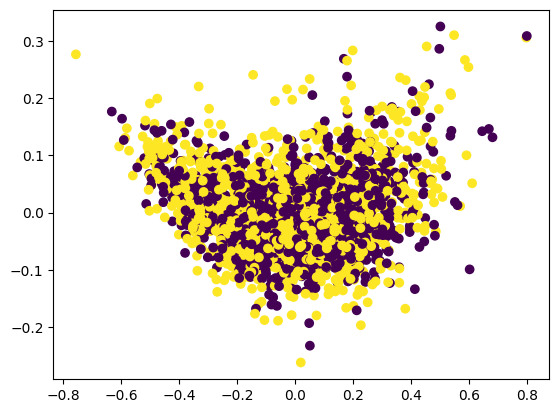

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(en_graphs, y, test_size=0.33, random_state=42, stratify=y)
X_train = X_train.reshape(-1, np.prod(en_graphs.shape[1:]))
X_test = X_test.reshape(-1, np.prod(en_graphs.shape[1:]))

pca = KernelPCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [101]:
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train), clf.score(X_test, y_test))
print(roc_auc_score(y_train,
                    clf.predict_proba(X_train)[:, 1]),
      roc_auc_score(y_test,
                    clf.predict_proba(X_test)[:, 1]))

0.7434402332361516 0.4977810650887574
0.871344414110167 0.4938956872631146
